In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFTGate as QFT, DiagonalGate as Diagonal
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error



# ==========================================
# 4. ANIMATION SETUP
# ==========================================


In [ ]:
# ==========================================
# 1. PHYSICS & GRID SETUP (Morse Potential)
# ==========================================
def get_morse_operators(n_qubits, L, mass, D, alpha, re):
    N = 2**n_qubits
    # Grid r >= 0. We start slightly offset from 0 to avoid singularities if any 
    # (though Morse is finite at 0).
    # Periodic BCs apply for FFT, so we must ensure V(0) and V(L) are high enough
    # or the wavepacket doesn't touch boundaries.
    r = np.linspace(0.0, L, N, endpoint=False)
    
    # Morse Potential V(r)
    # V(r) = D * (1 - exp(-alpha * (r - re)))^2
    V_r = D * (1 - np.exp(-alpha * (r - re)))**2
    
    # Kinetic T(k)
    # Standard FFT ordering k-values
    k_indices = np.arange(N)
    dk = 2 * np.pi / L
    k_values = np.where(k_indices < N/2, k_indices * dk, (k_indices - N) * dk)
    T_k = (k_values**2) / (2 * mass)
    
    return r, V_r, T_k

def get_initial_packet(n_qubits, r, r0, k0, sigma):
    # Gaussian wavepacket
    # For r0, we start far to the right.
    # k0 should be negative to move left towards the potential.
    psi = np.exp(-(r - r0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * r)
    psi = psi / np.linalg.norm(psi)
    return psi

# ==========================================
# 2. MODULAR NOISE FACTORY
# ==========================================
class NoiseFactory:
    @staticmethod
    def get_noiseless():
        return NoiseModel()

    @staticmethod
    def get_depolarizing(prob=0.001):
        noise_model = NoiseModel()
        # Error for single qubit gates
        error_1 = depolarizing_error(prob, 1)
        # Error for CX gates (QFT uses many CXs)
        error_2 = depolarizing_error(prob * 10, 2)
        
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'h'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        return noise_model
    
    @staticmethod
    def get_thermal(t1=50e3, t2=20e3, gate_time=50):
        """Simulates T1 (Relaxation) and T2 (Dephasing). Times in nanoseconds."""
        noise_model = NoiseModel()
        
        # Thermal error definition
        error = thermal_relaxation_error(t1, t2, gate_time)
        
        # Apply to relevant gates
        noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'h'])
        return noise_model

# ==========================================
# 3. STRANG SPLITTING SIMULATION (Qiskit)
# ==========================================
def run_morse_simulation(n_qubits, t_final, steps, noise_model):
    # --- System Parameters ---
    # We want the potential to be repulsive at r=0 to "contain" the particle 
    # naturally without needing hard-wall boundary conditions in the math.
    # r_e = 5.0 ensures r=0 is far up the repulsive wall.
    L = 25.0
    mass = 0.5
    D = 20.0
    alpha = 0.8
    re = 5.0 
    
    r_grid, V_grid, T_k = get_morse_operators(n_qubits, L, mass, D, alpha, re)
    
    # Initial State: Start at r=18.0, moving Left (k < 0)
    psi_0 = get_initial_packet(n_qubits, r_grid, r0=18.0, k0=-3.0, sigma=1.0)
    
    dt = t_final / steps
    
    # --- Build Operators (Strang) ---
    # U_strang = e^{-iV dt/2} e^{-iT dt} e^{-iV dt/2}
    
    op_V_half = Diagonal(np.exp(-1j * V_grid * (dt / 2)))
    op_T_full = Diagonal(np.exp(-1j * T_k * dt))
    
    # Simulator Setup
    # Note: With 7 qubits, density_matrix is fast enough (128x128).
    sim = AerSimulator(method='density_matrix', noise_model=noise_model)
    
    # Initialize Circuit
    qc = QuantumCircuit(n_qubits)
    qc.initialize(psi_0, range(n_qubits))
    
    results = []
    
    # Save t=0
    qc_temp = qc.copy()
    qc_temp.save_density_matrix()
    rho = sim.run(transpile(qc_temp, sim)).result().data()['density_matrix']
    results.append(np.real(np.diag(rho)))
    
    print(f"Running Morse Simulation (Noise={bool(noise_model.to_dict())})...")
    
    # QFT Object (Created once to reuse)
    qft = QFT(n_qubits)
    iqft = QFT(n_qubits).inverse()
    
    for _ in range(steps):
        # 1. Half Step V
        qc.append(op_V_half, range(n_qubits))
        
        # 2. Full Step T (Kinetic)
        qc.append(qft, range(n_qubits))
        qc.append(op_T_full, range(n_qubits))
        qc.append(iqft, range(n_qubits))
        
        # 3. Half Step V
        qc.append(op_V_half, range(n_qubits))
        
        # --- Snapshot ---
        qc_save = qc.copy()
        qc_save.save_density_matrix()
        
        # Transpile & Run
        # (Optimization: In a real app, transpile parts once. Here we transpile per step 
        # to handle the growing circuit, though usually one would append to a fresh state).
        job = sim.run(transpile(qc_save, sim))
        rho_data = job.result().data()['density_matrix']
        
        results.append(np.real(np.diag(rho_data)))
        
    return r_grid, V_grid, results

1. Simulating Ideal Case...
Running Morse Simulation (Noise=True)...
2. Simulating Noisy Case...Depolarizing
Running Morse Simulation (Noise=True)...
3. Simulating Noisy Case...Decoherence
Running Morse Simulation (Noise=True)...
Saving animation to 'morse_scattering_qiskit.gif'...
Saved successfully!


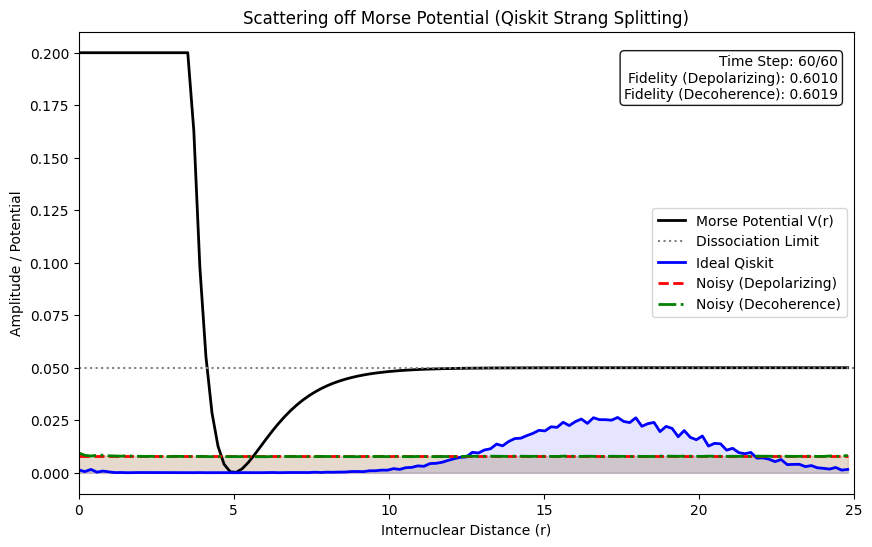

In [ ]:
n_qubits = 7        # 128 points for better Morse resolution
t_end = 5.0         # Enough time to bounce
n_steps = 60  # Frame count
D = 20.0      

# A. Run Ideal
print("1. Simulating Ideal Case...")
r, V, probs_ideal = run_morse_simulation(
    n_qubits, t_end, n_steps, NoiseFactory.get_noiseless()
)

# B. Run Noisy
print("2. Simulating Noisy Case...Depolarizing")
# A small error probability
r, _, probs_noisy = run_morse_simulation(
    n_qubits, t_end, n_steps, NoiseFactory.get_depolarizing(prob=0.0003)
)

print("3. Simulating Noisy Case...Decoherence")
# A small error probability
r, _, probs_noisy2 = run_morse_simulation(
    n_qubits, t_end, n_steps, NoiseFactory.get_thermal(t1=90e3, t2=80e3, gate_time=50)
)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Scattering off Morse Potential (Qiskit Strang Splitting)")
ax.set_xlabel("Internuclear Distance (r)")
ax.set_ylabel("Amplitude / Potential")
ax.set_xlim(0, 25)

# Plot Potential (Scaled down to fit plot)
# Morse potential goes to D at infinity.
# We scale it so D matches roughly the peak of the wavefunction for visibility.
target_height_for_D = 0.05
scale_factor = target_height_for_D / D  # Calculate scale based on D, not max(V)

# 2. CLAMP THE VISUAL POTENTIAL
# We create a copy of V just for plotting. 
# We clip it so it never draws higher than 4 times the well depth.
# This prevents the spike at r=0 from ruining the graph.
V_plot = np.minimum(V, D * 4.0)

# 3. PLOT
# Now plot V_plot instead of V
ax.plot(r, V_plot * scale_factor, 'k-', lw=2, label="Morse Potential V(r)")

# Optional: Draw a dashed line for the Dissociation Energy
ax.axhline(D * scale_factor, color='gray', linestyle=':', label="Dissociation Limit")

# Lines
line_ideal, = ax.plot([], [], 'b-', lw=2, label="Ideal Qiskit")
line_noisy, = ax.plot([], [], 'r--', lw=2, label="Noisy (Depolarizing)")
line_noisy2, = ax.plot([], [], 'g-.', lw=2, label="Noisy (Decoherence)")

# Fills
fill_ideal = ax.fill_between(r, 0, 0, color='blue', alpha=0.1)
fill_noisy = ax.fill_between(r, 0, 0, color='red', alpha=0.1)
fill_noisy2 = ax.fill_between(r, 0, 0, color='green', alpha=0.1)

stats_text = ax.text(0.98, 0.95, "", transform=ax.transAxes, 
                     ha='right', va='top',
                     bbox=dict(boxstyle="round", fc="white", alpha=0.9))

ax.legend(loc='center right')

def init():
    line_ideal.set_data([], [])
    line_noisy.set_data([], [])
    line_noisy2.set_data([], [])
    return line_ideal, line_noisy, line_noisy2

def update(frame):
    y_ideal = probs_ideal[frame]
    y_noisy = probs_noisy[frame]
    y_noisy2 = probs_noisy2[frame]
    
    # Clamp negatives (Numerical noise fix)
    y_ideal = np.maximum(y_ideal, 0.0)
    y_noisy = np.maximum(y_noisy, 0.0)
    y_noisy2 = np.maximum(y_noisy2, 0.0)
    
    # Update Data
    line_ideal.set_data(r, y_ideal)
    line_noisy.set_data(r, y_noisy)
    line_noisy2.set_data(r, y_noisy2)
    
    # Update Fills
    verts_i = np.vstack([np.hstack([r, r[::-1]]), 
                         np.hstack([y_ideal, np.zeros_like(y_ideal)])]).T
    fill_ideal.set_paths([verts_i])
    
    verts_n = np.vstack([np.hstack([r, r[::-1]]), 
                         np.hstack([y_noisy, np.zeros_like(y_noisy)])]).T
    fill_noisy.set_paths([verts_n])

    verts_n2 = np.vstack([np.hstack([r, r[::-1]]), 
                         np.hstack([y_noisy2, np.zeros_like(y_noisy2)])]).T
    fill_noisy2.set_paths([verts_n2])
    
    # Fidelity/Overlap
    overlap = np.sum(np.sqrt(y_ideal * y_noisy))**2
    overlap2 = np.sum(np.sqrt(y_ideal * y_noisy2))**2
  
    stats_text.set_text(f"Time Step: {frame}/{n_steps}\nFidelity (Depolarizing): {overlap:.4f}\nFidelity (Decoherence): {overlap2:.4f}")
    
    return line_ideal, line_noisy, fill_ideal, fill_noisy, stats_text

ani = FuncAnimation(fig, update, frames=len(probs_ideal), 
                    init_func=init, blit=False, interval=80)

# Save GIF
print("Saving animation to 'morse_scattering_qiskit.gif'...")
try:
    ani.save("morse_scattering_qiskit.gif", writer=PillowWriter(fps=15))
    print("Saved successfully!")
except Exception as e:
    print(f"Error saving GIF: {e}")

plt.show()